# Phase plots

Import packages:

In [1]:
import numpy as np
from numpy.polynomial import Polynomial as pol
from matplotlib import pyplot as plt
import matplotlib as mpl
import copy
import itertools
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from scipy.optimize import minimize

Import own modules:

In [2]:
import import_ipynb
from COSMETICS import *
from SETUP import f0, IinTprep, IinT, TSslow, f

importing Jupyter notebook from COSMETICS.ipynb
importing Jupyter notebook from SETUP.ipynb


In [3]:
plt.rc('font',**{'family':'sans-serif', 'sans-serif':['Arial'], 'size':20, 'weight':'normal'})
plt.rcParams['figure.constrained_layout.use'] = False

In [4]:
def get_eqlst(eqlst_pre):
    '''Helper function to select true equilibria from list of candidates'''
    eqlst = []
    for i in range(len(eqlst_pre)):
        Tval = eqlst_pre[i][0]
        flag = False
        j = 0
        while j in range(len(eqlst)) and flag == False:
            if abs(Tval-eqlst[j][0]) < 0.1: #or abs(eqlst_pre[i][1] - eqlst[j][1]) < 0.05:
                flag = True
                j += 1
            else:
                j += 1

        if flag == False:
            eqlst.append(eqlst_pre[i])
            
    return eqlst

## Phase plots

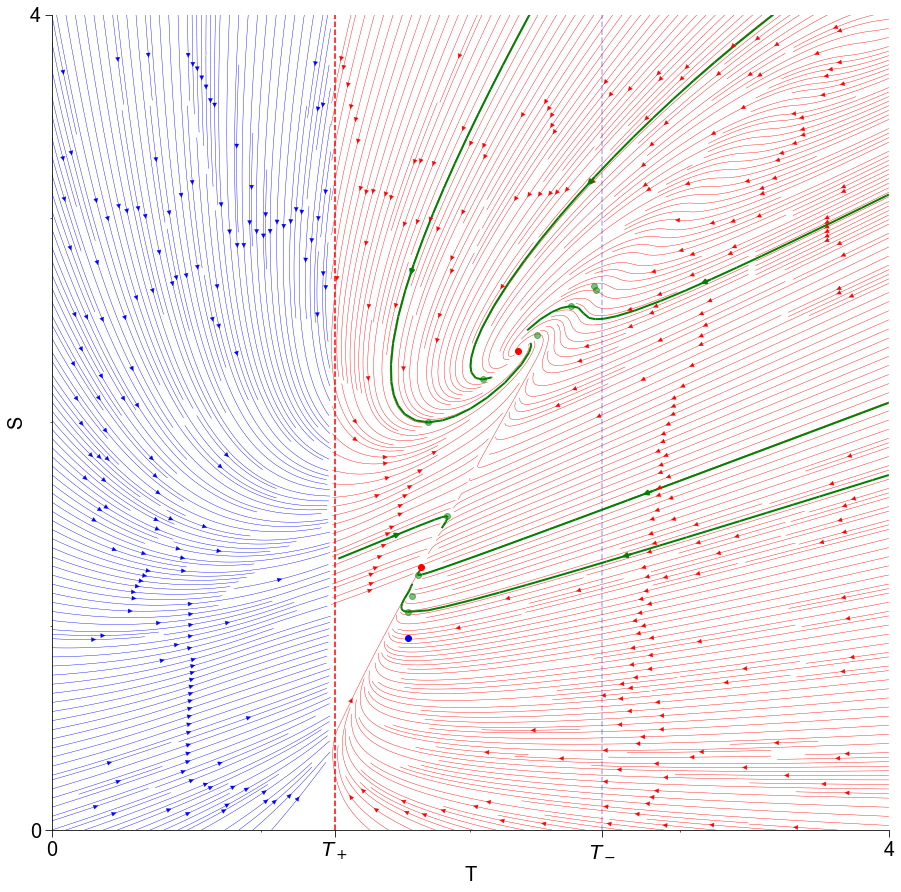

In [5]:
e1 = 3
e2 = 1
e3 = 0.3
D = 0.86
B = 0.45
R0 = -0.1
k = 0.303
dx = 0.01
T0 = 2.6 #2.88
S0 = 2.65 #2.92
t = 100
dt = 0.01

R = -0.5
c = 0.27
# i1 = np.arccosh(np.sqrt(D/(B-R0)))
# R_crit = -(c*max(f(e1-k*i1, e2, e3))[1] + D*np.tanh(i1) + (R0-B)*i1)
# print(R_crit)

T_max = 4
T_min = 0
S_max = 4
S_min = 0
ngrid = 100 #50
T = np.linspace(T_min, T_max, ngrid)
S = np.linspace(S_min, S_max, ngrid)
dTm = np.zeros((ngrid, ngrid))
dSm = np.zeros((ngrid, ngrid))
dTp = np.zeros((ngrid, ngrid))
dSp = np.zeros((ngrid, ngrid))
lw = 2


T_u, T_l, I_u, I_l = IinTprep(R, dx, c, Tmax=6, Imin=-4, Imax=4)
ice = [T_u, T_l, I_u, I_l]

# Set up vector field on M_0^+
for i in range(int(T_u[0]/4*ngrid)):
    for j in range(ngrid):
        dTm[j][i] = e1 - T[i]*(1+np.abs(T[i]-S[j]))
        dSm[j][i] = e2 - S[j]*(e3+np.abs(T[i]-S[j]))

# Set up vector field on M_0^-
for i in range(1+int(T_u[0]*ngrid/T_max), ngrid):
    for j in range(ngrid):
        I_term = 1
        I_term = IinT(T[i], I_term, R, dx, c, T_u, T_l, I_u, I_l)
        dTp[j][i] = e1 - k*np.heaviside(I_term, 0)*I_term - T[i]*(1+abs(T[i]-S[j]))
        dSp[j][i] = e2 - S[j]*(e3+abs(T[i]-S[j]))


##############
## Plotting ##
##############

plt.figure(figsize=(15,15))

## Vector fields
plt.streamplot(T, S, dTp, dSp, linewidth=0.4, density=6, color='red')
plt.streamplot(T, S, dTm, dSm, linewidth=0.4, density=6, color='blue')


## Some particular streamlines on M_0^+
start_points_p = [(1.8, 2), (2.06, 2.21), (2.32, 2.43), (2.48, 2.57), (2.59, 2.67), (2.6, 2.65),
             (1.89, 1.54), (1.75, 1.25), (1.72, 1.15), (1.70, 1.07)] # 1st line is off, 2nd is on

plt.streamplot(T, S, dTp, dSp, start_points = start_points_p, color='green', linewidth=lw)
for pt in start_points_p:
    if pt[0] > T_u[0]:
        plt.plot(pt[0], pt[1], 'go', alpha = 0.5) #, markersize=5


## Stable fixed points on M_0^+
eqlst_pre = []
for start_pt in start_points_p:
    T0 = start_pt[0]
    S0 = start_pt[1]

    if T_u[0] <= T0 <= T_u[-1]:
        time2, I2, T2, S2 = TSslow(t, dt, T0, S0, e1, e2, e3, k, c, R, dx, ice, I_branch=1)

        # we are looking for stable fixed points on M_0^+, so we must check whether
        # the system has tipped to an ice-free state; in that case, the
        # equilibrium is not appended to the candidate list, and for clarity
        # a print statement is made. 
        if I2[-1] > 0:
            eqlst_pre.append((T2[-1], S2[-1], I2[-1], T0))

eqlst = get_eqlst(eqlst_pre) 

for pt in eqlst:
    if pt[0] > T_u[0]:
            plt.plot(pt[0], pt[1], 'ro')


## Some particular streamlines on M_0^-
basin_bdry_points = np.array([[2.82, 2.757], [2.8251452061765026, 2.763252885229169]])
plt.streamplot(T, S, dTm, dSm, start_points = basin_bdry_points, color='green', linewidth=lw)


## Fixed points on M_0^-
for pt in f(e1, e2, e3):
    if pt[1] < T_l[-1]:
        plt.plot(pt[1], pt[0], 'bo')
        
        
## Temperature thresholds
ax=plt.gca()

if T_u[0] < T_l[-1]:
    alpha = 0.3
else:
    alpha = 1
    
plt.vlines(x = T_u[0], ymin = 0, ymax = 4, colors = 'red', ls='--')
plt.vlines(x = T_l[-1], ymin = 0, ymax = 4, colors = 'blue', alpha=alpha, ls='--')


## Plotting ticks
xticks = [0,4]
xticklabels = [0,4]
yticks = [0,4]
yticklabels = [0,4]

if len(T_u) != 0 and T_u[0] > 1e-4:
    xticks = np.append(xticks, T_u[0])
    xticklabels = np.append(xticklabels, '$T_+$')


if len(T_l) != 0 and T_l[-1] < 4-1e-4:
    xticks = np.append(xticks, T_l[-1])
    xticklabels = np.append(xticklabels, '$T_-$')

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)


## Plotting labels etc.
plt.xlabel('T')
plt.ylabel('S')
plt.show()

In [6]:
# e1range = np.arange(3.00, 2.40, -0.005)
e1range = np.arange(2.90, 2.88, -0.0001)
for e1 in e1range:
    if len(f(e1, 1.0, 0.3)) == 3:
        print(e1, min(f(e1, 1.0, 0.3))[1])
    else:
        print('monostability')

2.9 1.7000340029718548
2.8998999999999997 1.7000333320750183
2.8997999999999995 1.7000326677492557
2.8996999999999993 1.7000320099979682
2.899599999999999 1.7000313588245561
2.899499999999999 1.7000307142324236
2.8993999999999986 1.7000300762249783
2.8992999999999984 1.7000294448056315
2.8991999999999982 1.7000288199777938
2.899099999999998 1.7000282017448802
2.898999999999998 1.7000275901103084
2.8988999999999976 1.7000269850774976
2.8987999999999974 1.7000263866498713
2.898699999999997 1.7000257948308537
2.898599999999997 1.7000252096238726
2.8984999999999967 1.7000246310323595
2.8983999999999965 1.700024059059746
2.8982999999999963 1.7000234937094667
2.898199999999996 1.7000229349849603
2.898099999999996 1.7000223828896683
2.8979999999999957 1.700021837427034
2.8978999999999955 1.700021298600501
2.8977999999999953 1.70002076641352
2.897699999999995 1.700020240869541
2.897599999999995 1.7000197219720175
2.8974999999999946 1.7000192097244053
2.8973999999999944 1.7000187041301635
2.897

[0.08, -0.1288827155847439, -0.28, -0.36375938114606904, -0.38, -0.44, -0.47477105698168043, -0.6821763653147955, -0.7]
1
Tpl 0.0 -1.073845859096675
Tmin 0.659100785037523 0.659100785037523
0.0 [(2.367281644963014, 2.4718387747468644, 2.5510078201965656, 1.8), (2.367281644963053, 2.471838774746883, 2.5510078201965802, 2.06), (2.3672816449630063, 2.471838774746843, 2.5510078201965625, 2.32), (2.3672816449629863, 2.471838774746841, 2.5510078201965554, 2.48), (2.3672816449629766, 2.4718387747468324, 2.5510078201965514, 2.59), (2.3672816449629766, 2.4718387747468324, 2.5510078201965514, 2.6), (2.3672816449629646, 2.4718387747468222, 2.551007820196547, 2.7370359674823024), (1.736171028898149, 1.2091303121563803, 2.309908262550251, 1.89), (1.736171028898149, 1.2091303121563803, 2.309908262550251, 1.75), (1.7361710288981125, 1.209130312156323, 2.309908262550237, 1.72), (1.7361710288981125, 1.209130312156323, 2.309908262550237, 1.7), (1.7361710288981125, 1.209130312156323, 2.309908262550237, 1

Tpl 2.826154140903325 2.826154140903325
Tmin 4.559100785037523 4.559100785037523
2.826154140903325 []
2.826154140903325 []
2.877897690767868 4.559100785037523
1.7035143629612424 4.559100785037523



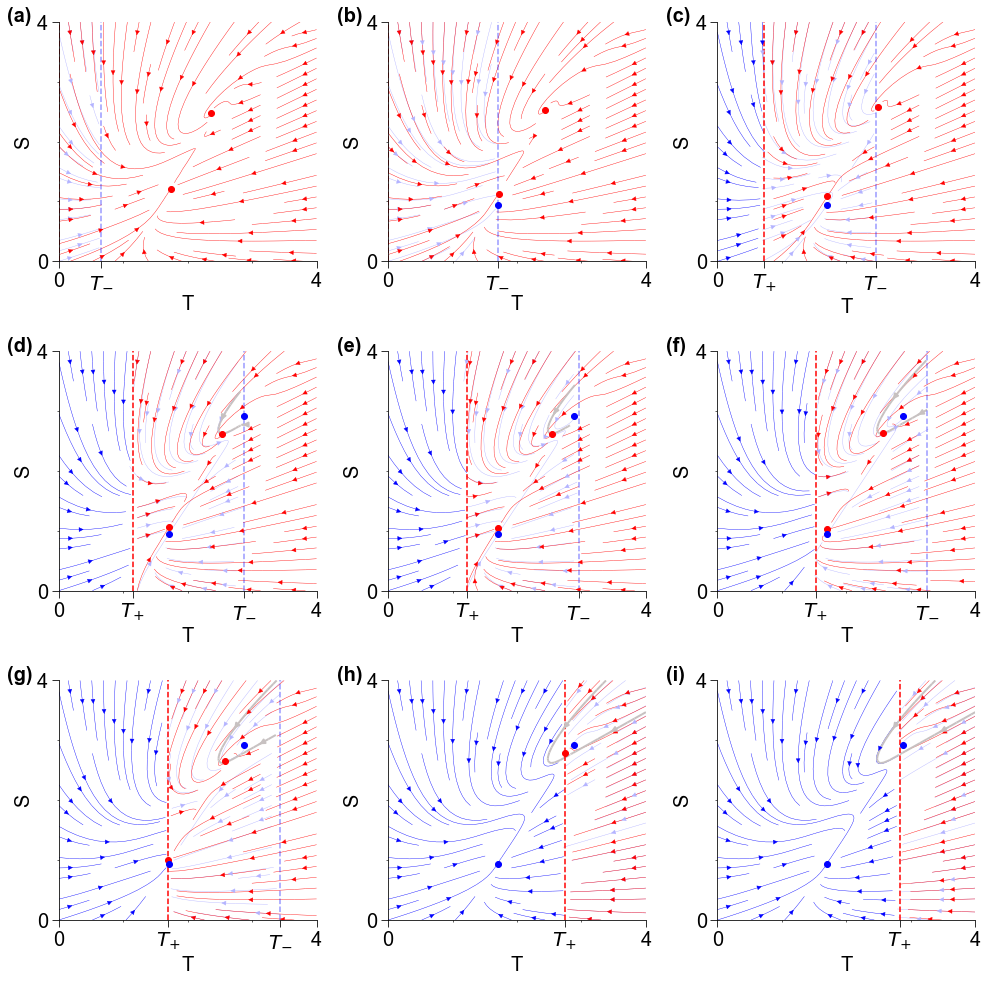

In [7]:
from matplotlib.colors import ListedColormap, BoundaryNorm

e1 = 3
e2 = 1
e3 = 0.3
D = 0.86
B = 0.45
R0 = -0.1
k = 0.151
dx = 0.005
T0 = 2.6 #2.88
S0 = 2.65 #2.92
t = 100
dt = 0.01

c = 0.2
i1 = np.arccosh(np.sqrt(D/(B-R0)))
i2 = -np.arccosh(np.sqrt(D/B))
lpl = D*np.tanh(i1) + (R0-B)*i1
lmin = D*np.tanh(i2) - B*i2

R_crit1 = -(c*min(f(e1, e2, e3))[1] + D*np.tanh(i2) - B*i2) # R_on
R_crit2 = -(c*max(f(e1, e2, e3))[1] + D*np.tanh(i2) - B*i2)
R_crit4 = -(c*min(f(e1-k*i1, e2, e3))[1] + D*np.tanh(i1) + (R0-B)*i1)
R_crit5 = -(c*max(f(e1-k*i1, e2, e3))[1] + D*np.tanh(i1) + (R0-B)*i1)

T_sn = 1.8968299744885446
e1_sn = 2.549292519519159
I_sn = (e1-e1_sn)/k
R_sn = -(D*np.tanh(I_sn) + (R0-B)*I_sn)
R_crit3 = R_sn - c*T_sn
# print(R_crit5)

# print(R_crit4, R_crit3, R_crit2, R_crit1)
# Rlst = [0.01, (R_crit1+0.01)/2, R_crit1+0.01, R_crit1, R_crit1-0.01, R_crit1-0.05]
# Rlst = [0.08, R_crit1, R_crit2, R_crit3, -0.46, R_crit4, R_crit5, -0.66, -0.7] #

Rlst = [0.08, R_crit1, -0.28, R_crit2, -0.38, -0.44, R_crit4, R_crit5+1e-12, -0.7]# R_crit1, -0.64, R_crit4, R_crit2, -1.2, R_crit5]
print(Rlst)

T_max = 4
T_min = 0
S_max = 4
S_min = 0
ngrid = 100
T = np.linspace(T_min, T_max, ngrid)
S = np.linspace(S_min, S_max, ngrid)
lw = 2
density = 0.8

dT = np.zeros((ngrid, ngrid))
dS = np.zeros((ngrid, ngrid)) 

## Set up vector field on M_0^-
for i in range(ngrid):
    for j in range(ngrid):
        dT[j][i] = e1 - T[i]*(1+np.abs(T[i]-S[j]))
        dS[j][i] = e2 - S[j]*(e3+np.abs(T[i]-S[j]))


##############
## Plotting ##
##############
plt.figure(figsize=(14,14))
plt_ind = 1

for R in Rlst:
    print(plt_ind)
    
    dTm = np.zeros((ngrid, ngrid))
    dSm = np.zeros((ngrid, ngrid))
    dTm2 = np.zeros((ngrid, ngrid))
    dSm2 = np.zeros((ngrid, ngrid))
    dTm3 = np.zeros((ngrid, ngrid))
    dSm3 = np.zeros((ngrid, ngrid))
    dTp = np.zeros((ngrid, ngrid))
    dSp = np.zeros((ngrid, ngrid))
    
    if plt_ind == 1:
        ax1 = plt.subplot(3,3,1)
        
    else:
        plt.subplot(3,3,plt_ind, sharey=ax1) #sharex=ax1
    
    T_u, T_l, I_u, I_l = IinTprep(R, dx, c, Tmax=10, Imin=-10, Imax=10)
    T_l[-1] = -1/c*(lmin+R)
    ice = [T_u, T_l, I_u, I_l]
    print('Tpl', T_u[0], -1/c*(lpl+R))
    print('Tmin', T_l[-1], -1/c*(lmin+R))

    ## Set up vector field on M_0^-
    for i in range(int(min(T_u[0]/4*ngrid, ngrid))):
        for j in range(ngrid):
            dTm[j][i] = dT[j][i]
            dSm[j][i] = dS[j][i]
    
    if T_u[0] < 4:
        for i in range(int(T_u[0]/4*ngrid), min(int(T_l[-1]/4*ngrid), ngrid)):
            for j in range(ngrid):
                dTm2[j][i] = dT[j][i]
                dSm2[j][i] = dS[j][i]
                
    for i in range(int(min(T_l[-1]/4*ngrid, ngrid))):
        for j in range(ngrid):
            dTm3[j][i] = dT[j][i]
            dSm3[j][i] = dS[j][i]

    ## Set up vector field on M_0^+
    for i in range(1+int(T_u[0]*ngrid/T_max), ngrid):
        for j in range(ngrid):
            I_term = 1
            I_term = IinT(T[i], I_term, R, dx, c, T_u, T_l, I_u, I_l)
            dTp[j][i] = e1 - k*np.heaviside(I_term, 0)*I_term - T[i]*(1+abs(T[i]-S[j]))
            dSp[j][i] = e2 - S[j]*(e3+abs(T[i]-S[j]))
            
    
    ## Vector fields
    plt.streamplot(T, S, dTm2, dSm2, linewidth=0.4, density=density, color='#B3B3FF')
    plt.streamplot(T, S, dTm, dSm, linewidth=0.4, density=density, color='blue')
    plt.streamplot(T, S, dTp, dSp, linewidth=0.4, density=density, color='red')
    
    ## Some particular streamlines on M_0^+
    start_points_p = [(1.8, 2), (2.06, 2.21), (2.32, 2.43), (2.48, 2.57), (2.59, 2.67), (2.6, 2.65), (max(f(e1-k*i1, e2, e3))[1], max(f(e1-k*i1, e2, e3))[0]),
                 (1.89, 1.54), (1.75, 1.25), (1.72, 1.15), (1.70, 1.07), (min(f(e1-k*i1, e2, e3))[1], min(f(e1-k*i1, e2, e3))[0])] # 1st line is off, 2nd is on

#     plt.streamplot(T, S, dTp, dSp, start_points = start_points_p, color='green', linewidth=lw)
#     for pt in start_points_p:
#         if pt[0] > T_u[0]:
#             plt.plot(pt[0], pt[1], 'go', alpha = 0.5) #, markersize=5


    ## Stable fixed points on M_0^+
    eqlst_pre = []
    for start_pt in start_points_p:
        T0 = start_pt[0]
        S0 = start_pt[1]

        if T_u[0]-0.0001 <= T0 <= T_u[-1]:
            time2, I2, T2, S2 = TSslow(t, dt, T0, S0, e1, e2, e3, k, c, R, dx, ice, I_branch=1)

            # we are looking for stable fixed points on M_0^+, so we must check whether
            # the system has tipped to an ice-free state; in that case, the
            # equilibrium is not appended to the candidate list.
            if I2[-1] > 0:
                eqlst_pre.append((T2[-1], S2[-1], I2[-1], T0))
    
    print(T_u[0], eqlst_pre)
    eqlst = get_eqlst(eqlst_pre)
    print(T_u[0], eqlst)

    for pt in eqlst:
        if pt[0] > T_u[0]-0.001:
                plt.plot(pt[0], pt[1], 'ro')


    ## Some particular streamlines on M_0^- 
#     basin_bdry_points = [(2.8251452061765026, 2.763252885229169), (2.82, 2.757)] #(2.82, 2.757),
#     color = 
    basin_bdry_points = [(2.822, 2.76), (2.83, 2.768)]
#     cmap = ListedColormap(['blue', '#B3B3FF'])
#     norm = BoundaryNorm([0, T_u[0], 4], cmap.N)
#     plt.streamplot(T, S, dTm3, dSm3, start_points = basin_bdry_points, color=['blue', '#B3B3FF'], cmap=cmap, norm=norm, linewidth=lw, integration_direction='backward')
    plt.streamplot(T, S, dTm3, dSm3, start_points = basin_bdry_points, color='#C7C1C1', linewidth=lw, integration_direction='backward')

    ## Fixed points on M_0^-
    for pt in [max(f(e1, e2, e3)), min(f(e1, e2, e3))]:
        print(pt[1], T_l[-1])
        if pt[1] < T_l[-1]+0.05:
            plt.plot(pt[1], pt[0], 'bo')


    ## Temperature thresholds
    ax=plt.gca()

    if T_u[0] < T_l[-1]:
        alpha = 0.4
    else:
        alpha = 1

    plt.vlines(x = T_u[0], ymin = 0, ymax = 4, colors = 'red', ls='--')
    plt.vlines(x = T_l[-1], ymin = 0, ymax = 4, colors = 'blue', alpha=alpha, ls='--')


    ## Plotting ticks
    xticks = [0,4]
    xticklabels = [0,4]
    yticks = [0,4]
    yticklabels = [0,4]

    if len(T_u) != 0 and 0.5 < T_u[0] < 3.5:
        xticks = np.append(xticks, T_u[0])
        xticklabels = np.append(xticklabels, '$T_{\!+}$')


    if len(T_l) != 0 and 0.5 < T_l[-1] < 3.5:
        xticks = np.append(xticks, T_l[-1])
        xticklabels = np.append(xticklabels, '$T_{\!-}$')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)


    ## Plotting labels etc.
    plt.xlabel('T')
    plt.ylabel('S')
    plt.xlim(0,4)
    plt.ylim(0,4)
    
    dic = {1: '(a)', 2: '(b)', 3: '(c)', 4: '(d)', 5: '(e)', 6: '(f)', 7: '(g)', 8: '(h)', 9: '(i)'}
    plt.text(-0.8, 4, dic[plt_ind], weight='bold')
    
    plt_ind += 1
    print('')
    
plt.tight_layout(pad=1)
# plt.savefig('thresholdsk0151c02.pdf', bbox_inches='tight')
plt.show()

## Movies

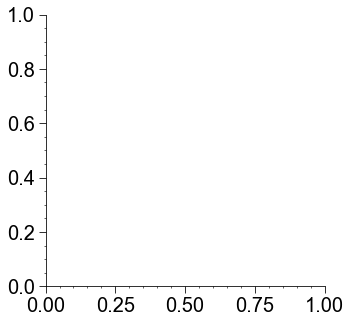

In [140]:
from matplotlib.colors import ListedColormap, BoundaryNorm

e1 = 3
e2 = 1
e3 = 0.3
D = 0.86
B = 0.45
R0 = -0.1
k = 0.38
dx = 0.01
T0 = 2.6 #2.88
S0 = 2.65 #2.92
t = 100
dt = 0.01

c = 0.2
i1 = np.arccosh(np.sqrt(D/(B-R0)))
i2 = -np.arccosh(np.sqrt(D/B))
lpl = D*np.tanh(i1) + (R0-B)*i1
lmin = D*np.tanh(i2) - B*i2

R_crit1 = -(c*min(f(e1, e2, e3))[1] + D*np.tanh(i2) - B*i2) # R_on
R_crit2 = -(c*max(f(e1, e2, e3))[1] + D*np.tanh(i2) - B*i2)
R_crit4 = -(c*min(f(e1-k*i1, e2, e3))[1] + D*np.tanh(i1) + (R0-B)*i1)
R_crit5 = -(c*max(f(e1-k*i1, e2, e3))[1] + D*np.tanh(i1) + (R0-B)*i1)

T_sn = 1.8968299744885446
e1_sn = 2.549292519519159
I_sn = (e1-e1_sn)/k
lsn = -(D*np.tanh(I_sn) + (R0-B)*I_sn)
R_sn = lsn - c*T_sn

T_max = 4
T_min = 0
S_max = 4
S_min = 0
ngrid = 100
T = np.linspace(T_min, T_max, ngrid)
S = np.linspace(S_min, S_max, ngrid)
lw = 2
density = 1.1

dT = np.zeros((ngrid, ngrid))
dS = np.zeros((ngrid, ngrid)) 

## Set up vector field on M_0^-
for i in range(ngrid):
    for j in range(ngrid):
        dT[j][i] = e1 - T[i]*(1+np.abs(T[i]-S[j]))
        dS[j][i] = e2 - S[j]*(e3+np.abs(T[i]-S[j]))

stable_eqs_M0_min = [max(f(e1, e2, e3)), min(f(e1, e2, e3))]

##############
## Plotting ##
##############

fig, ax = plt.subplots(figsize=(5,5))

def animate(R):
    print(R)
    ax.clear()
    ax.set_title(f'R={np.around(R, decimals=3)}')
    
    dTm = np.zeros((ngrid, ngrid))
    dSm = np.zeros((ngrid, ngrid))
    dTm2 = np.zeros((ngrid, ngrid))
    dSm2 = np.zeros((ngrid, ngrid))
    dTm3 = np.zeros((ngrid, ngrid))
    dSm3 = np.zeros((ngrid, ngrid))
    dTp = np.zeros((ngrid, ngrid))
    dSp = np.zeros((ngrid, ngrid))
    
    T_u, T_l, I_u, I_l = IinTprep(R, dx, c, Tmax=15, Imin=-15, Imax=15)
    
    if len(T_l) != 0:
        T_l[-1] = -1/c*(lmin+R)
    else:
        T_l = [-1/c*(lmin+R)]
        
    ice = [T_u, T_l, I_u, I_l]

    ## Set up vector field on M_0^-
    for i in range(int(min(T_u[0]/4*ngrid, ngrid))):
        for j in range(ngrid):
            dTm[j][i] = dT[j][i]
            dSm[j][i] = dS[j][i]
    
    if T_u[0] < 4:
        for i in range(int(T_u[0]/4*ngrid), min(int(T_l[-1]/4*ngrid), ngrid)):
            for j in range(ngrid):
                dTm2[j][i] = dT[j][i]
                dSm2[j][i] = dS[j][i]
                
    for i in range(int(min(T_l[-1]/4*ngrid, ngrid))):
        for j in range(ngrid):
            dTm3[j][i] = dT[j][i]
            dSm3[j][i] = dS[j][i]

    ## Set up vector field on M_0^+
    for i in range(1+int(T_u[0]*ngrid/T_max), ngrid):
        for j in range(ngrid):
            I_term = 1
            I_term = IinT(T[i], I_term, R, dx, c, T_u, T_l, I_u, I_l)
            dTp[j][i] = e1 - k*np.heaviside(I_term, 0)*I_term - T[i]*(1+abs(T[i]-S[j]))
            dSp[j][i] = e2 - S[j]*(e3+abs(T[i]-S[j]))        
    
    ## Vector fields
    ax.streamplot(T, S, dTm2, dSm2, linewidth=0.4, density=density, color='#B3B3FF')
    ax.streamplot(T, S, dTm, dSm, linewidth=0.4, density=density, color='blue')
    ax.streamplot(T, S, dTp, dSp, linewidth=0.4, density=density, color='red')
    
    ## Some particular streamlines on M_0^+
    start_points_p = [(1.8, 2), (2.06, 2.21), (2.32, 2.43), (2.48, 2.57), (2.59, 2.67), (2.6, 2.65), (max(f(e1-k*i1, e2, e3))[1], max(f(e1-k*i1, e2, e3))[0]),
                 (1.89, 1.54), (1.75, 1.25), (1.72, 1.15), (1.70, 1.07), (min(f(e1-k*i1, e2, e3))[1], min(f(e1-k*i1, e2, e3))[0])] # 1st line is off, 2nd is on


    ## Stable fixed points on M_0^+
    eqlst_pre = []
    for start_pt in start_points_p:
        T0 = start_pt[0]
        S0 = start_pt[1]

        if T_u[0]-0.0001 <= T0 <= T_u[-1]:
            time2, I2, T2, S2 = TSslow(t, dt, T0, S0, e1, e2, e3, k, c, R, dx, ice, I_branch=1)

            # we are looking for stable fixed points on M_0^+, so we must check whether
            # the system has tipped to an ice-free state; in that case, the
            # equilibrium is not appended to the candidate list.
            if I2[-1] > 0:
                eqlst_pre.append((T2[-1], S2[-1], I2[-1], T0))
    
    eqlst = get_eqlst(eqlst_pre)

    for pt in eqlst:
        if pt[0] > T_u[0]-0.001:
                ax.plot(pt[0], pt[1], 'ro')


    ## Basin boundary on M_0^- 
    basin_bdry_points = [(2.822, 2.76), (2.83, 2.768)]
    ax.streamplot(T, S, dTm3, dSm3, start_points = basin_bdry_points, color='#C7C1C1', linewidth=lw, integration_direction='backward')

    ## Fixed points on M_0^-
    for pt in stable_eqs_M0_min:
        if pt[1] < T_l[-1]+0.05:
            ax.plot(pt[1], pt[0], 'bo')


    if T_u[0] < T_l[-1]:
        alpha = 0.4
    else:
        alpha = 1

    ax.vlines(x = T_u[0], ymin = 0, ymax = 4, colors = 'red', ls='--')
    ax.vlines(x = T_l[-1], ymin = 0, ymax = 4, colors = 'blue', alpha=alpha, ls='--')


    ## Plotting ticks
    xticks = [0,4]
    xticklabels = [0,4]
    yticks = [0,4]
    yticklabels = [0,4]

    if len(T_u) != 0 and 0.5 < T_u[0] < 3.5:
        xticks = np.append(xticks, T_u[0])
        xticklabels = np.append(xticklabels, '$T_{\!+}$')


    if len(T_l) != 0 and 0.5 < T_l[-1] < 3.5:
        xticks = np.append(xticks, T_l[-1])
        xticklabels = np.append(xticklabels, '$T_{\!-}$')

    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)


    ## Plotting labels etc.
    ax.set_xlabel('T') 
    ax.set_ylabel('S') 
    ax.set_xlim(0,4)
    ax.set_ylim(0,4)
    
    return fig, ax

In [141]:
ani = animation.FuncAnimation(fig, animate, np.arange(0.4, -1.1, -0.005), interval=400, blit=False)

In [142]:
writer = animation.FFMpegWriter(fps=8, metadata=dict(artist='Me'), bitrate=4000)
# ani.save("k038c02.mp4", writer=writer)

0.4
0.4
0.395
0.39
0.385
0.38
0.375
0.37
0.365
0.36
0.355
0.35
0.345
0.33999999999999997
0.33499999999999996
0.32999999999999996
0.32499999999999996
0.31999999999999995
0.31499999999999995
0.30999999999999994
0.30499999999999994
0.29999999999999993
0.29499999999999993
0.2899999999999999
0.2849999999999999
0.2799999999999999
0.2749999999999999
0.2699999999999999
0.2649999999999999
0.2599999999999999
0.2549999999999999
0.2499999999999999
0.24499999999999988
0.23999999999999988
0.23499999999999988
0.22999999999999987
0.22499999999999987
0.21999999999999986
0.21499999999999986
0.20999999999999985
0.20499999999999985
0.19999999999999984
0.19499999999999984
0.18999999999999984
0.18499999999999983
0.17999999999999983
0.17499999999999982
0.16999999999999982
0.1649999999999998
0.1599999999999998
0.1549999999999998
0.1499999999999998
0.1449999999999998
0.1399999999999998
0.1349999999999998
0.12999999999999978
0.12499999999999978
0.11999999999999977
0.11499999999999977
0.10999999999999976
0.10499